## Getting Started

- Download MapPLUTO data from [NYC DCP](https://s-media.nyc.gov/agencies/dcp/assets/files/zip/data-tools/bytes/nyc_mappluto_24v1_1_shp.zip)
- Unzip the file and place contents in the `Data` directory at the root of this repo
- Make sure you have installed all requisite libraries by running `pip install -r requirements.txt` **_with your virtual environment activated_**

## Goals

- Load data from file
- Explore spatial and non-spatial elements of the dataset
- Compare tradeoffs between different methods of loading data
- Demonstrate tradeoffs in different file formats


In [1]:
# the bare minimum
import matplotlib.pyplot as plt
import geopandas as gpd

# more advanced
import pyogrio as ogr
from sklearn.cluster import KMeans
from lonboard import Map, PolygonLayer
from lonboard.colormap import apply_categorical_cmap, apply_continuous_cmap
from palettable.colorbrewer.sequential import PuRd_9
from matplotlib.colors import LogNorm

import pydeck as pdk

# load PLUTO data


In [2]:
# pluto = gpd.read_file("../Data/nyc_mappluto_24v1_1_shp/MapPLUTO.shp")

In [3]:
# pluto_ogrio = ogr.read_dataframe("../Data/nyc_pluto_24v2_csv/pluto_24v2.csv")
pluto_ogrio = ogr.read_dataframe("../Data/nyc_mappluto_24v1_1_shp/MapPLUTO.shp")

# basic exploration


In [4]:
pluto_ogrio.columns

Index(['Borough', 'Block', 'Lot', 'CD', 'BCT2020', 'BCTCB2020', 'CT2010',
       'CB2010', 'SchoolDist', 'Council', 'ZipCode', 'FireComp', 'PolicePrct',
       'HealthCent', 'HealthArea', 'Sanitboro', 'SanitDistr', 'SanitSub',
       'Address', 'ZoneDist1', 'ZoneDist2', 'ZoneDist3', 'ZoneDist4',
       'Overlay1', 'Overlay2', 'SPDist1', 'SPDist2', 'SPDist3', 'LtdHeight',
       'SplitZone', 'BldgClass', 'LandUse', 'Easements', 'OwnerType',
       'OwnerName', 'LotArea', 'BldgArea', 'ComArea', 'ResArea', 'OfficeArea',
       'RetailArea', 'GarageArea', 'StrgeArea', 'FactryArea', 'OtherArea',
       'AreaSource', 'NumBldgs', 'NumFloors', 'UnitsRes', 'UnitsTotal',
       'LotFront', 'LotDepth', 'BldgFront', 'BldgDepth', 'Ext', 'ProxCode',
       'IrrLotCode', 'LotType', 'BsmtCode', 'AssessLand', 'AssessTot',
       'ExemptTot', 'YearBuilt', 'YearAlter1', 'YearAlter2', 'HistDist',
       'Landmark', 'BuiltFAR', 'ResidFAR', 'CommFAR', 'FacilFAR', 'BoroCode',
       'BBL', 'CondoNo', 'Tract2

In [5]:
pluto_ogrio.dtypes

Borough         object
Block            int64
Lot              int32
CD               int32
BCT2020         object
                ...   
Longitude      float64
Notes           object
Shape_Leng     float64
Shape_Area     float64
geometry      geometry
Length: 95, dtype: object

## categorical column


In [6]:
pluto_ogrio.LandUse.value_counts()

LandUse
01    565933
02    131623
04     55966
11     24904
05     21260
03     12916
08     12052
06      9431
10      9344
07      6033
09      4708
Name: count, dtype: int64

🧐 What do those numbers mean? Let's look at the [data dictionary](https://s-media.nyc.gov/agencies/dcp/assets/files/pdf/data-tools/bytes/meta_mappluto.pdf)


In [7]:
# now we can remap the numbers into something more meaningful

land_use_codes = {
    "01": "One & Two Family Buildings",
    "02": "Multi-Family Walk-Up Buildings",
    "03": "Multi-Family Elevator Buildings",
    "04": "Mixed Residential & Commercial Buildings",
    "05": "Commercial & Office Buildings",
    "06": "Industrial & Manufacturing",
    "07": "Transportation & Utility",
    "08": "Public Facilities & Institutions",
    "09": "Open Space & Outdoor Recreation",
    "10": "Parking Facilities",
    "11": "Vacant Land",
}

In [8]:
pluto_ogrio["LandUse"] = pluto_ogrio.LandUse.map(land_use_codes)

## Your turn:

- How many lots of each land use type are there?
  - Use `groupby` to determine the number of lots of each land use type
- What is the lot area of each land use type?
  - Use `groupby` to make a bar chart that shows the average lot area of each land use type
- Can you find the total number of lots that contain `Commercial & Office Buildings` in the Bronx?
  - use groupby on multiple columns to achieve this
- Can you find the share of each land use type in each borough?


In [9]:
pluto_ogrio.groupby("LandUse").value_counts()


Series([], Name: count, dtype: int64)

Text(0.5, 1.0, 'Average lot area by land use type')

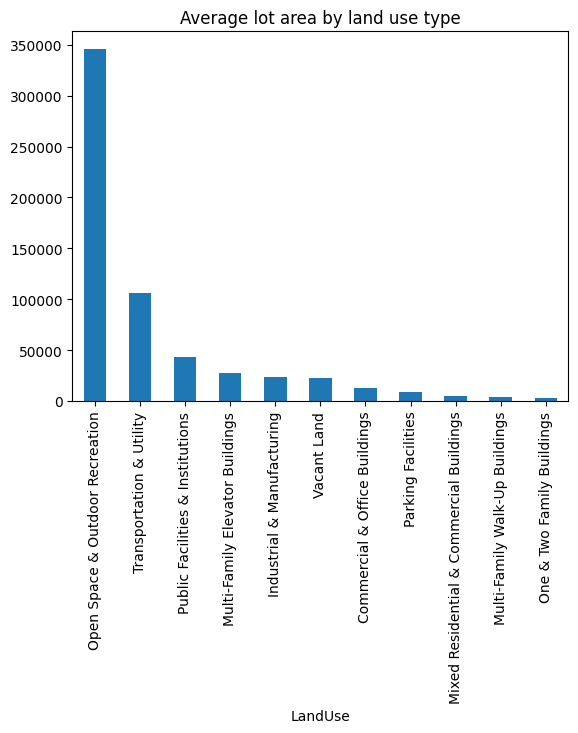

In [10]:
pluto_ogrio.groupby(["LandUse"]).LotArea.mean().sort_values(ascending=False).plot.bar()
plt.title("Average lot area by land use type")

In [11]:
pluto_ogrio.groupby(["LandUse", "Borough"]).size().unstack().fillna(0)

Borough,BK,BX,MN,QN,SI
LandUse,,,,,
Commercial & Office Buildings,5594,2886,4575,6213,1992
Industrial & Manufacturing,4009,1233,205,3451,533
Mixed Residential & Commercial Buildings,24671,4353,12067,13151,1724
Multi-Family Elevator Buildings,3635,2366,4853,1972,90
Multi-Family Walk-Up Buildings,65209,17876,11395,35292,1851
One & Two Family Buildings,155870,51141,4155,246766,108001
Open Space & Outdoor Recreation,1225,697,582,976,1228
Parking Facilities,3002,1839,548,3293,662
Public Facilities & Institutions,4223,1926,2379,2783,741


<Axes: xlabel='Borough'>

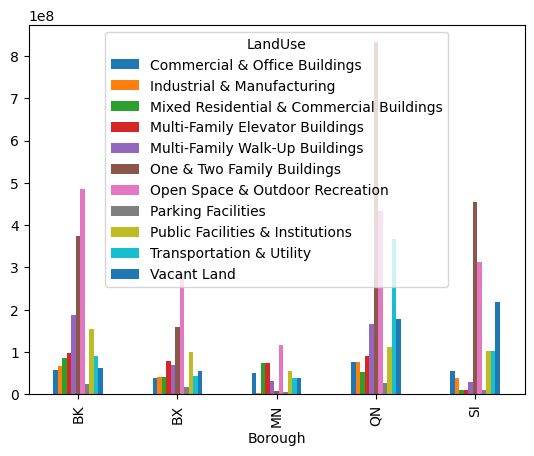

In [12]:
pluto_ogrio.groupby(["Borough", "LandUse"]).LotArea.sum().unstack().plot.bar()

## Okay, now let's look at lot and building area


Text(0.5, 1.0, 'Total lot area by land use type')

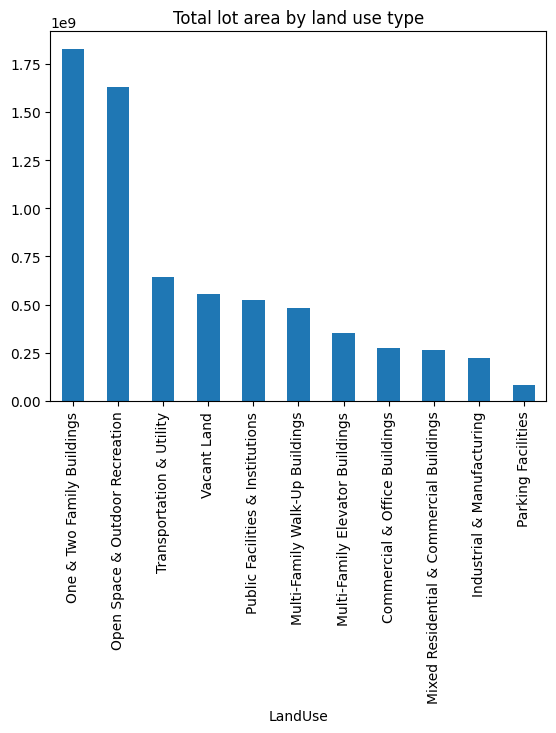

In [13]:
pluto_ogrio.groupby(["LandUse"]).LotArea.sum().sort_values(ascending=False).plot.bar()
plt.title("Total lot area by land use type")

Text(0.5, 1.0, 'Total building area by land use type')

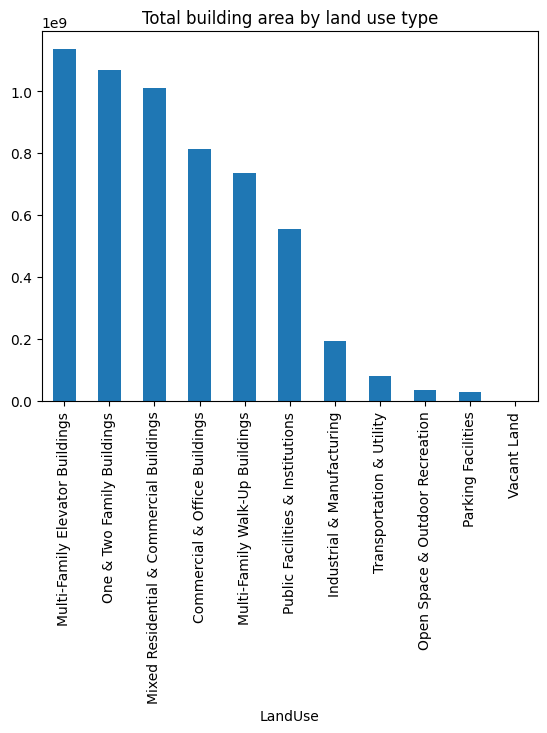

In [14]:
# now the same but for building area
pluto_ogrio.groupby("LandUse").BldgArea.sum().sort_values(ascending=False).plot.bar()
plt.title("Total building area by land use type")

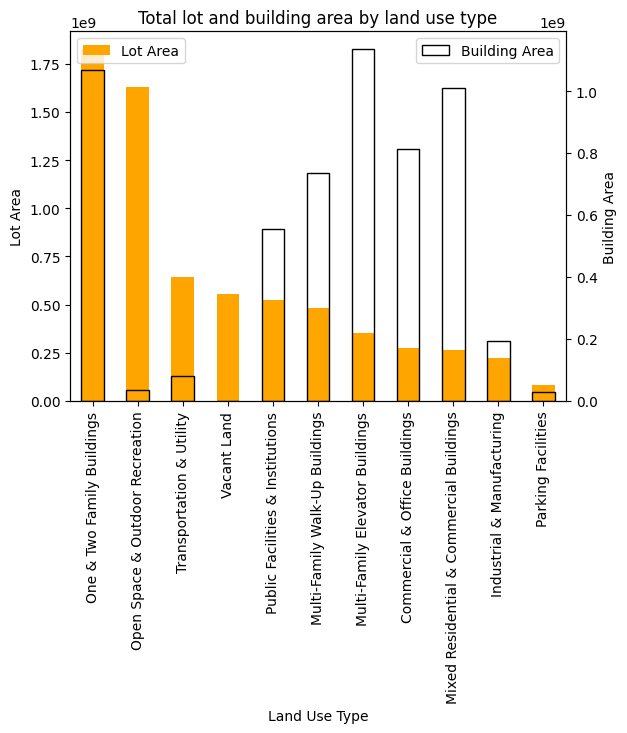

In [15]:
# plot both lot and building area on the same plot with a secondary y-axis
fig, ax = plt.subplots()
by_lot_area = pluto_ogrio.groupby("LandUse").LotArea.sum().sort_values(ascending=False)

by_lot_area.plot.bar(ax=ax, color="orange")

# get order to apply below
order = {v: i for i, v in enumerate(by_lot_area.index)}

ax.set_ylabel("Lot Area")
ax.set_xlabel("Land Use Type")

ax2 = ax.twinx()
pluto_ogrio.groupby("LandUse").BldgArea.sum().reindex(by_lot_area.index).plot.bar(
    ax=ax2, edgecolor="black", color="none"
)
ax2.set_ylabel("Building Area")

plt.title("Total lot and building area by land use type")

# add legends
ax.legend(["Lot Area"], loc="upper left")
ax2.legend(["Building Area"], loc="upper right")

## numeric column


In [16]:
pluto_ogrio["NumFloors"].describe()

count    856819.000000
mean          2.357554
std           2.012707
min           0.000000
25%           2.000000
50%           2.000000
75%           2.500000
max         104.000000
Name: NumFloors, dtype: float64

<Axes: ylabel='Frequency'>

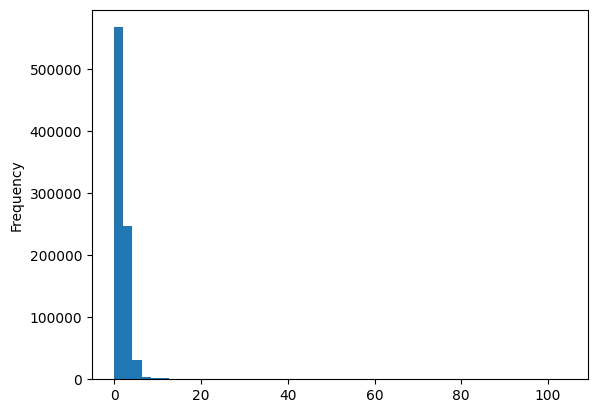

In [17]:
pluto_ogrio["NumFloors"].plot.hist(bins=50)

## Your turn:

- make a histogram for each borough like above
- then, choose another chart type to visualize the distribution of lot area for each borough. See [here](https://matplotlib.org/stable/plot_types/index.html) for some built in options in matplotlib, or here for [seaborn](https://seaborn.pydata.org/tutorial/distributions.html)


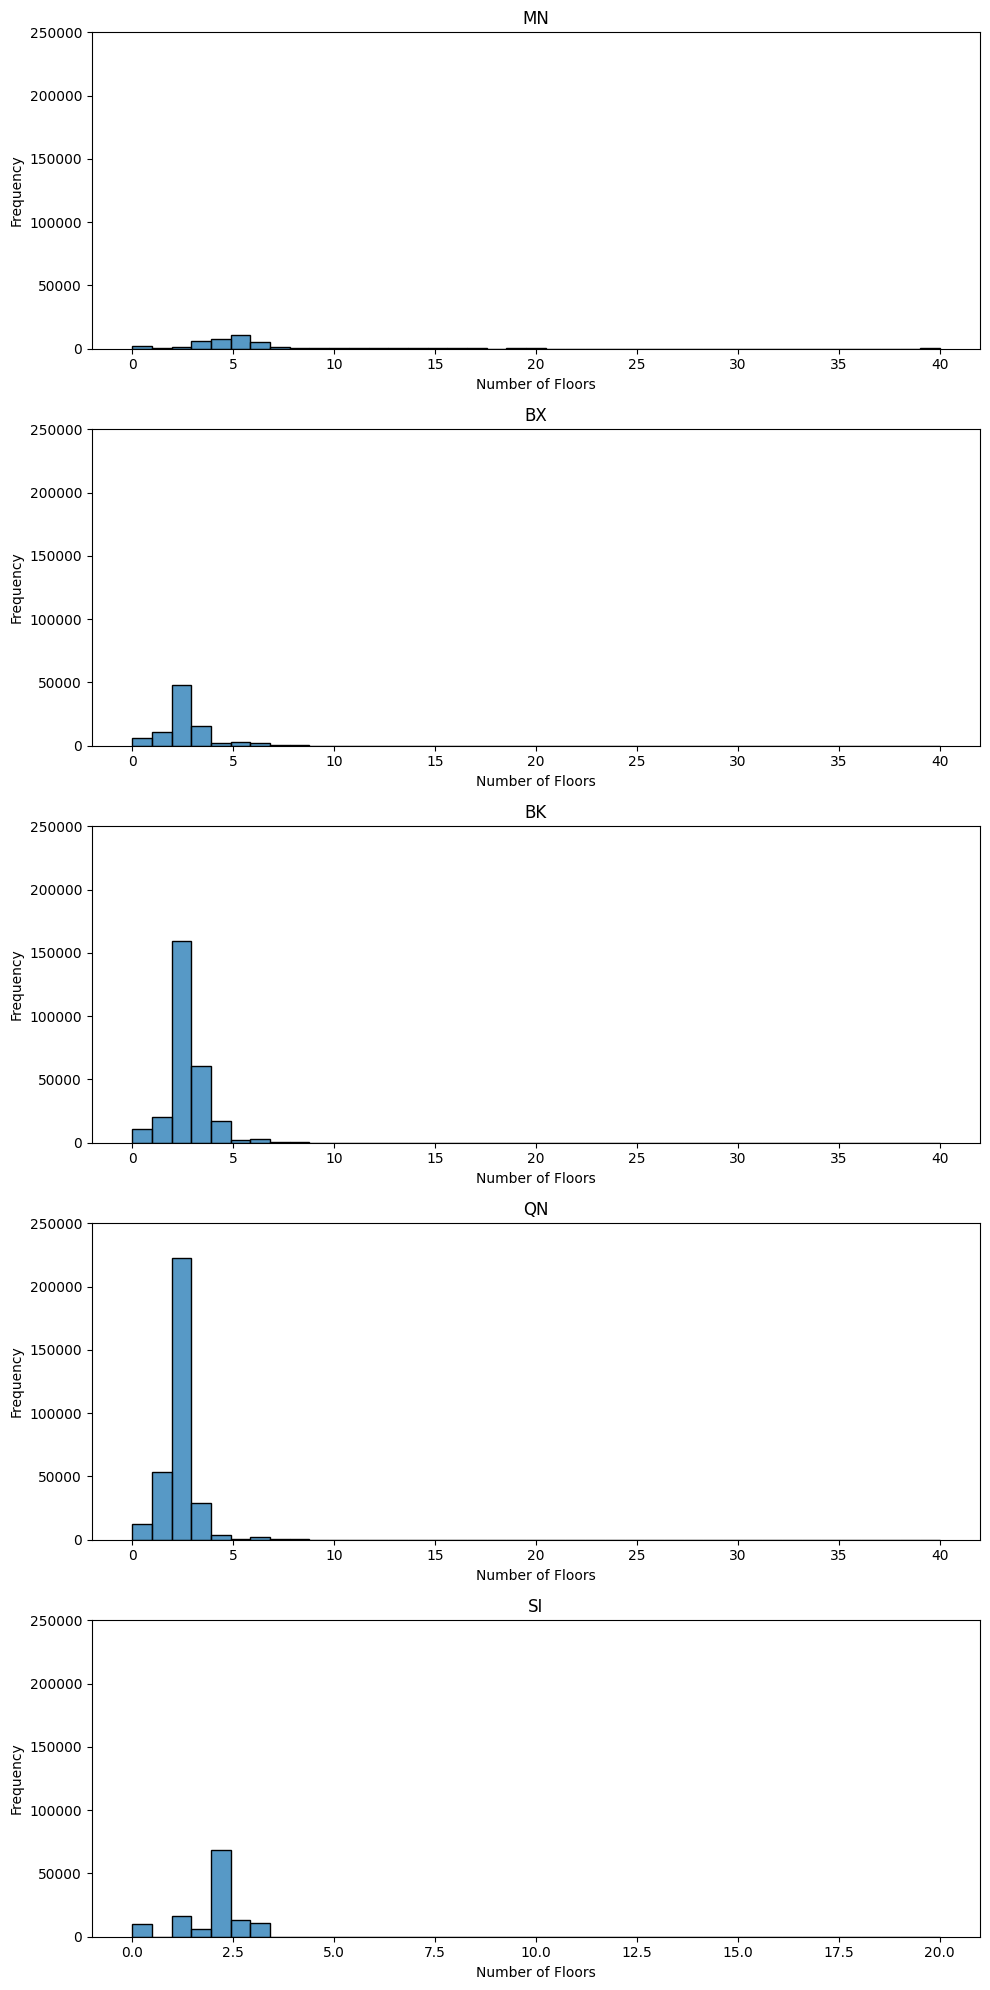

In [18]:
import seaborn
# Bucket anything over 40 floors in the same bin
pluto_ogrio["NumFloorsBucketed"] = pluto_ogrio["NumFloors"].apply(lambda x: 40 if x > 40 else x)

# Generate histograms for each borough
boroughs = pluto_ogrio["Borough"].unique()
fig, axes = plt.subplots(nrows=len(boroughs), ncols=1, figsize=(10, 20))

# Determine the maximum y-axis limit for all histograms
max_y = max(pluto_ogrio["NumFloorsBucketed"].value_counts().max() for borough in boroughs)

for ax, borough in zip(axes, boroughs):
    seaborn.histplot(pluto_ogrio[pluto_ogrio["Borough"] == borough]["NumFloorsBucketed"], bins=41, ax=ax)
    ax.set_title(borough)
    ax.set_xlabel("Number of Floors")
    ax.set_ylabel("Frequency")
    ax.set_ylim(0, 250000)

plt.tight_layout()
plt.show()

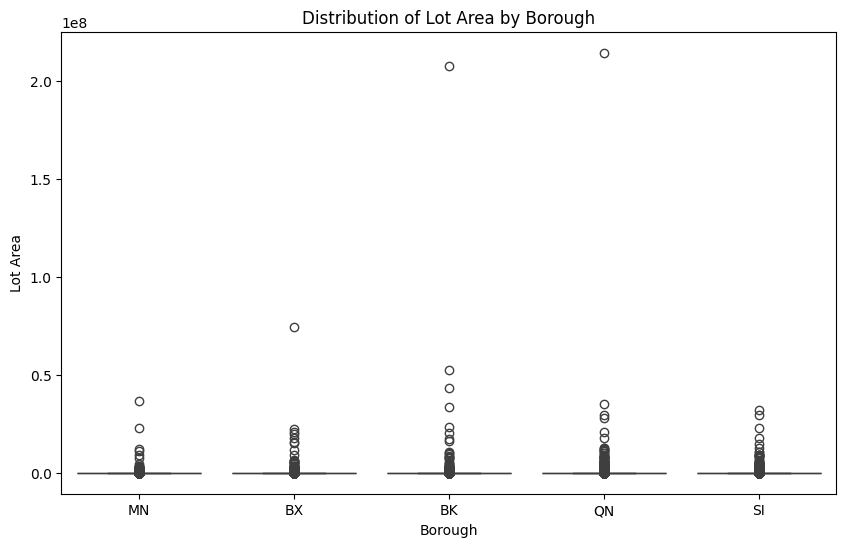

In [19]:

# Generate a boxplot to visualize the distribution of lot area for each borough
plt.figure(figsize=(10, 6))
seaborn.boxplot(x="Borough", y="LotArea", data=pluto_ogrio)
plt.title("Distribution of Lot Area by Borough")
plt.xlabel("Borough")
plt.ylabel("Lot Area")
plt.show()


## Ok, now let's make a boxplot to see how wide the range is within each boro's data


<Axes: title={'center': 'NumFloors'}, xlabel='Borough'>

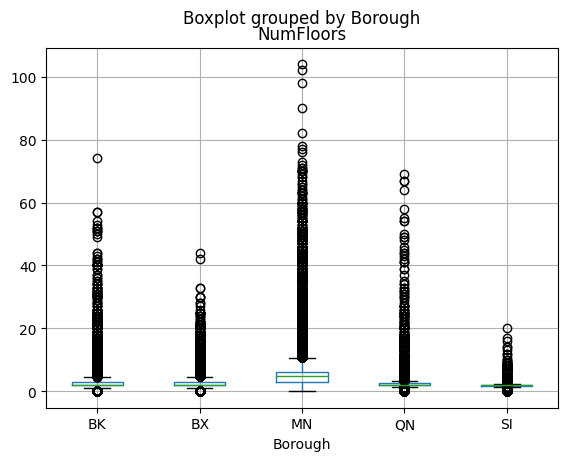

In [20]:
pluto_ogrio.boxplot(column="NumFloors", by="Borough")

What does this distribution tell us about the number of floors in each borough?


Manhattan has the highest building outliers, as well as the highest average, but most of the buildings in NYC are between 2 and about 6 floors. 

# cluster by number of floors


In [21]:
# get clusters using kmeans

kmeans = KMeans(n_clusters=5)
kmeans.fit(pluto_ogrio[["NumFloors", "ResArea"]])

pluto_ogrio["NumFloorsCluster"] = kmeans.predict(pluto_ogrio[["NumFloors", "ResArea"]])

In [22]:
pluto_ogrio.groupby("NumFloorsCluster").NumFloors.describe().sort_values("max")

,count,mean,std,min,25%,50%,75%,max
NumFloorsCluster,,,,,,,,
1,4.0,23.250000,11.265730,13.0,13.75,23.5,33.00,33.0
3,64.0,20.273438,14.365117,0.0,13.75,18.5,21.75,72.0
4,9184.0,9.505635,6.804971,0.0,6.00,6.0,12.00,82.0
2,954.0,23.240566,15.519224,0.0,12.00,20.0,32.00,98.0
0,846613.0,2.255027,1.492678,0.0,2.00,2.0,2.50,104.0


In [23]:
pluto_ogrio.plot.scatter(x="NumFloors", y="ResArea", c="NumFloorsCluster", cmap="tab10")

<Axes: xlabel='NumFloors', ylabel='ResArea'>

<Axes: xlabel='NumFloors', ylabel='ResArea'>

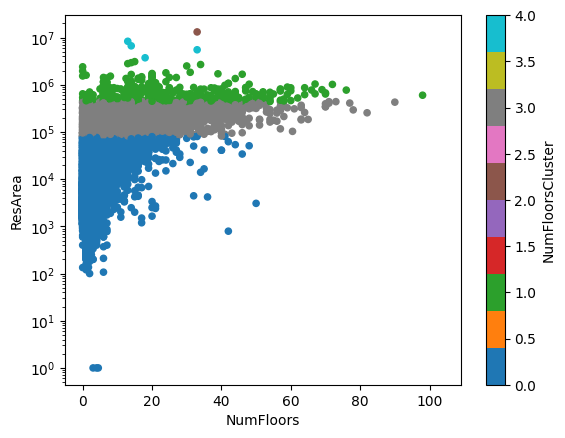

In [ ]:
# same as above but with log y axis
pluto_ogrio.plot.scatter(
    x="NumFloors", y="ResArea", c="NumFloorsCluster", cmap="tab10", logy=True
)

<Axes: ylabel='Frequency'>

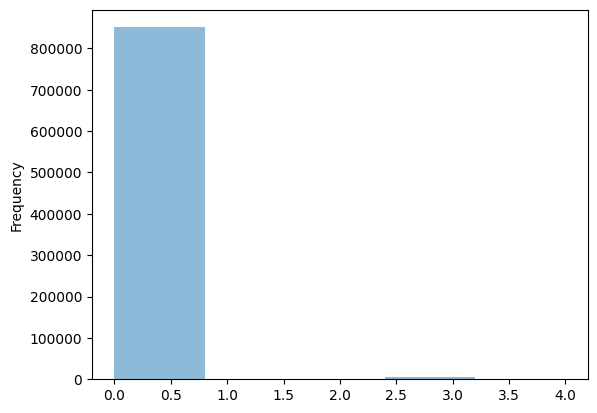

In [ ]:
pluto_ogrio["NumFloorsCluster"].plot.hist(bins=5, alpha=0.5)

# and now, mapping


## static map


Text(0.5, 1.0, 'NYC MapPLUTO')

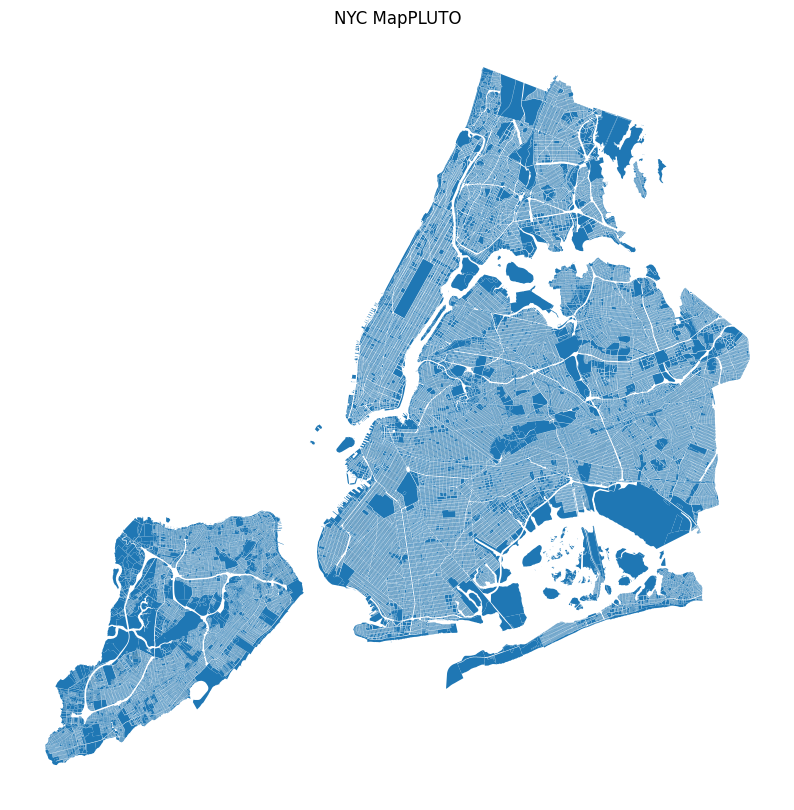

In [ ]:
pluto_ogrio.plot(figsize=(10, 10)).set_axis_off()
plt.title("NYC MapPLUTO")

In [ ]:
cmap = {
    "One & Two Family Buildings": "#ff0000",
    "Multi-Family Walk-Up Buildings": "#00ff00",
    "Multi-Family Elevator Buildings": "#0000ff",
    "Mixed Residential & Commercial Buildings": "#ff00ff",
    "Commercial & Office Buildings": "#00ffff",
    "Industrial & Manufacturing": "#ffff00",
    "Transportation & Utility": "#808080",
    "Public Facilities & Institutions": "#800000",
    "Open Space & Outdoor Recreation": "#008000",
    "Parking Facilities": "#000080",
    "Vacant Land": "#800080",
    "Unknown": "#000000",
}

In [ ]:
pluto_ogrio.fillna({"LandUse": "Unknown"}, inplace=True)

In [ ]:
pluto_ogrio["color"] = pluto_ogrio["LandUse"].map(cmap)

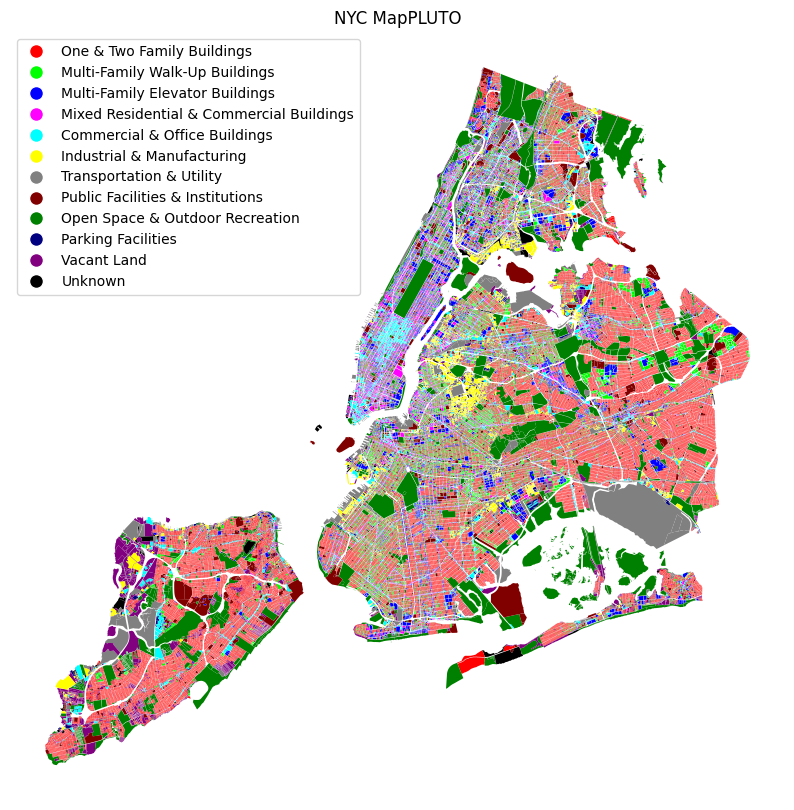

In [ ]:
ax = pluto_ogrio.plot(
    color=pluto_ogrio["color"],
    figsize=(10, 10),
    legend=True,
).set_axis_off()
plt.title("NYC MapPLUTO")


# populate legend items based on dict from above
legend_colors = [
    plt.Line2D([0], [0], marker="o", color="w", markerfacecolor=c, markersize=10)
    for c in cmap.values()
]
labels = cmap.keys()
plt.legend(legend_colors, labels, loc="upper left")

Text(0.5, 1.0, 'NYC MapPLUTO')

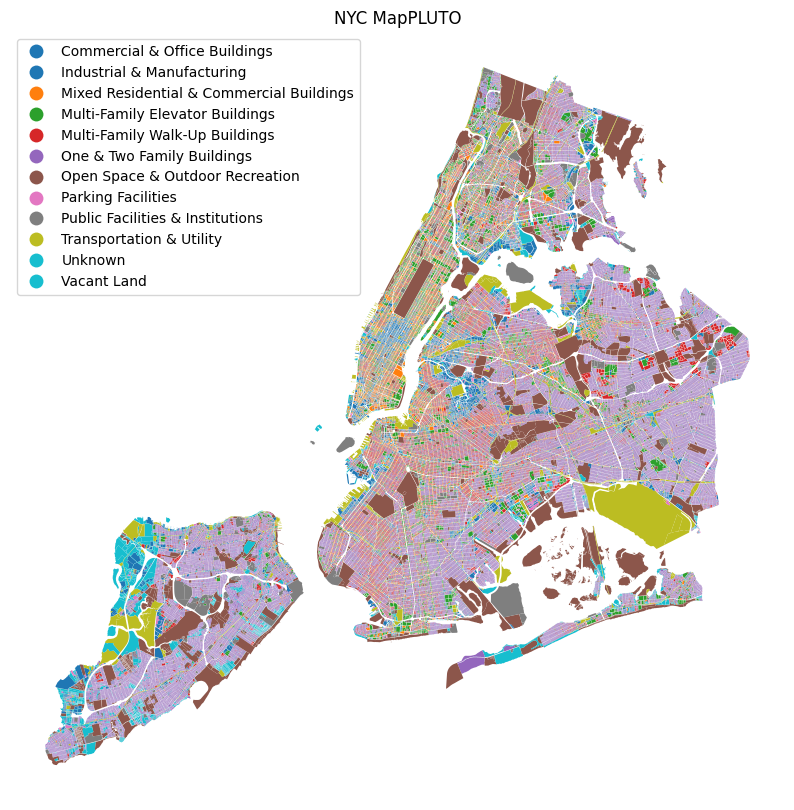

In [ ]:
pluto_ogrio.plot(
    column="LandUse", figsize=(10, 10), legend=True, legend_kwds={"loc": "upper left"}
).set_axis_off()
plt.title("NYC MapPLUTO")

## Your turn:

- map a numeric column using a continuous colormap for Queens. See here for a list and discussion of colormaps: https://matplotlib.org/stable/tutorials/colors/colormaps.html
- What patterns emerge?


Text(0.5, 1.0, 'NYC MapPLUTO Year Built')

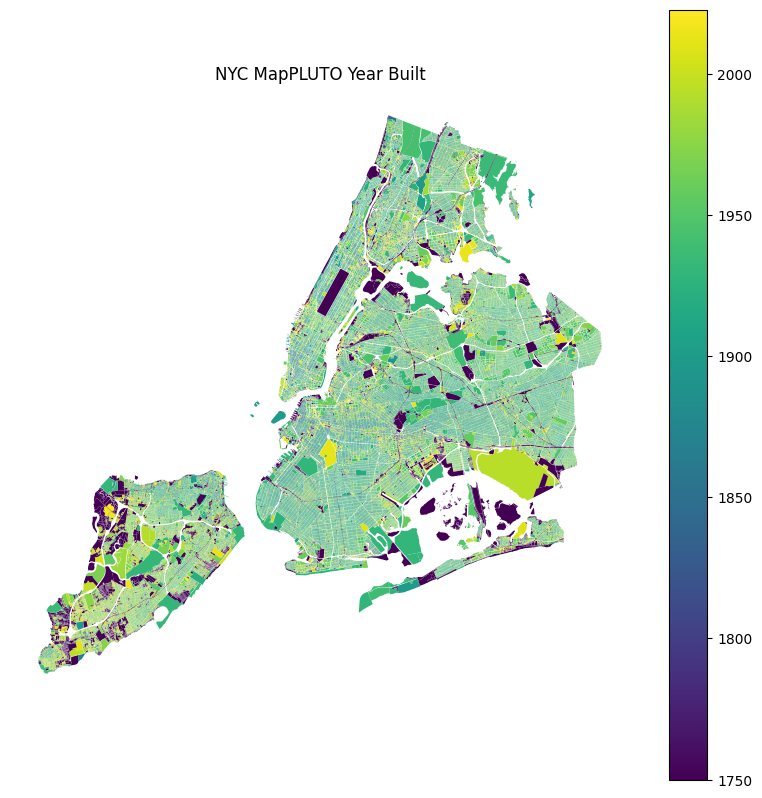

In [ ]:
pluto_ogrio.plot(
    column="YearBuilt", figsize=(10, 10), legend=True, 
    vmin=1750, vmax=pluto_ogrio["YearBuilt"].max()
).set_axis_off()
plt.title("NYC MapPLUTO Year Built")

# prep for interactive mapping


In [ ]:
pluto_ogrio_wgs = pluto_ogrio.to_crs("epsg:4326")

## visualize a categorical variable


In [ ]:
cmap_rgb = {k: list(int(v[i : i + 2], 16) for i in (1, 3, 5)) for k, v in cmap.items()}

In [ ]:
cmap_rgb

{'One & Two Family Buildings': [255, 0, 0],
 'Multi-Family Walk-Up Buildings': [0, 255, 0],
 'Multi-Family Elevator Buildings': [0, 0, 255],
 'Mixed Residential & Commercial Buildings': [255, 0, 255],
 'Commercial & Office Buildings': [0, 255, 255],
 'Industrial & Manufacturing': [255, 255, 0],
 'Transportation & Utility': [128, 128, 128],
 'Public Facilities & Institutions': [128, 0, 0],
 'Open Space & Outdoor Recreation': [0, 128, 0],
 'Parking Facilities': [0, 0, 128],
 'Vacant Land': [128, 0, 128],
 'Unknown': [0, 0, 0]}

In [ ]:
len(pluto_ogrio_wgs[pluto_ogrio_wgs["LandUse"].isna()])

0

In [ ]:
pluto_ogrio_wgs["LandUse"].fillna("Unknown", inplace=True)

/var/folders/1_/c48g_s_x3g742m1fsz_ytz840000gn/T/ipykernel_77554/961482650.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  pluto_ogrio_wgs["LandUse"].fillna("Unknown", inplace=True)


## uhoh- observe the above warning- re-write the code to avoid this


In [ ]:
pluto_ogrio_wgs["LandUse"] = pluto_ogrio_wgs["LandUse"].fillna("Unknown")

In [ ]:
df

,LandUse,geometry
0,08,"POLYGON ((-74.01208 40.69205, -74.01215 40.692..."
1,02,"POLYGON ((-74.00202 40.70791, -74.00198 40.707..."
2,04,"POLYGON ((-74.00213 40.70784, -74.00199 40.707..."
3,04,"POLYGON ((-74.00231 40.70776, -74.00224 40.707..."
4,04,"POLYGON ((-74.00271 40.70731, -74.00278 40.707..."
...,...,...
856814,01,"POLYGON ((-74.25065 40.50927, -74.25055 40.509..."
856815,01,"POLYGON ((-74.25009 40.50929, -74.25015 40.509..."
856816,01,"POLYGON ((-74.24997 40.50916, -74.25004 40.509..."
856817,01,"POLYGON ((-74.24983 40.50903, -74.24990 40.509..."


## now, we can plot the data using lonboard to create an interactive map


In [ ]:
df = pluto_ogrio_wgs[["LandUse", "geometry"]]

layer = PolygonLayer.from_geopandas(
    df[["LandUse", "geometry"]],
    get_fill_color=apply_categorical_cmap(df["LandUse"], cmap=cmap_rgb),
)
m = Map(layer)
m

Map(layers=[PolygonLayer(get_fill_color=<pyarrow.lib.FixedSizeListArray object at 0x2e0359d80>
[
  [
    128,
…

In [ ]:
pluto_ogrio_wgs["LandUse"] = pluto_ogrio_wgs["LandUse"].astype("category")

In [ ]:
df = pluto_ogrio_wgs[["LandUse", "geometry"]]

layer = PolygonLayer.from_geopandas(
    df[["LandUse", "geometry"]],
    get_fill_color=apply_categorical_cmap(df["LandUse"], cmap=cmap_rgb),
)
m = Map(layer)
m

Map(layers=[PolygonLayer(get_fill_color=<pyarrow.lib.FixedSizeListArray object at 0x2e0359600>
[
  [
    128,
…

In [ ]:
pluto_ogrio_wgs[pluto_ogrio_wgs.geometry.isna()]

,Borough,Block,Lot,CD,BCT2020,BCTCB2020,CT2010,CB2010,SchoolDist,Council,...,DCPEdited,Latitude,Longitude,Notes,Shape_Leng,Shape_Area,geometry,NumFloorsBucketed,NumFloorsCluster,color


## visualize a continuous variable


In [ ]:
df = pluto_ogrio_wgs[["NumFloors", "geometry"]]

normalizer = LogNorm(1, df.NumFloors.max(), clip=True)
normalized_floors = normalizer(df.NumFloors)

layer = PolygonLayer.from_geopandas(
    df[["NumFloors", "geometry"]],
    get_fill_color=apply_continuous_cmap(normalized_floors, cmap=PuRd_9),
)
m = Map(layer)
m

Map(layers=[PolygonLayer(get_fill_color=<pyarrow.lib.FixedSizeListArray object at 0x2e03581c0>
[
  [
    210,
…

## your turn: can you make the above show in 3d?

- see here for some tips: https://developmentseed.org/lonboard/latest/examples/overture-maps/#imports


In [ ]:
from lonboard import Map, PolygonLayer

df = pluto_ogrio_wgs[["NumFloors", "geometry"]]

# Normalize the number of floors for color mapping
normalizer = LogNorm(1, df.NumFloors.max(), clip=True)
normalized_floors = normalizer(df.NumFloors)

# Create a 3D layer with height based on the number of floors
layer = PolygonLayer.from_geopandas(
    df[["NumFloors", "geometry"]],
    get_fill_color=apply_continuous_cmap(normalized_floors, cmap=PuRd_9),
    get_elevation=df["NumFloors"],
    elevation_scale=10,
    extruded=True,
)

# Create the map
m = Map(layers=[layer])
m



Map(layers=[PolygonLayer(elevation_scale=10.0, extruded=True, get_elevation=<pyarrow.lib.FloatArray object at …

# save data


In [ ]:
# save out as fgb using geopandas
# pluto_ogrio.to_file("..Data/nyc_mappluto_24v1_1_shp/mappluto.fgb")

In [ ]:
# ogr.write_dataframe(pluto_ogrio, "../Data/nyc_mappluto_24v1_1_shp/mappluto_ogr.fgb")